# protostars
## 05- Solid angle ratio
### III. What are the units?

We solve the problem in this notebook!

gully  
March 10, 2017

In [1]:
import pandas as pd

### Phoenix
see Husser et al. 2013

In [2]:
import Starfish
from Starfish.grid_tools import PHOENIXGridInterfaceNoAlpha as PHOENIX
mygrid = PHOENIX(norm=False, base='/Users/gully/GitHub/Starfish/libraries/raw/PHOENIX/')

/Users/gully/GitHub/Starfish/Starfish/__init__.py:16: UserWarning: Using the default config.yaml file located at /Users/gully/GitHub/Starfish/Starfish/config.yaml. This is likely NOT what you want. Please create a similar 'config.yaml' file in your current working directory.
  warnings.warn("Using the default config.yaml file located at {0}. This is likely NOT what you want. Please create a similar 'config.yaml' file in your current working directory.".format(default), UserWarning)


From the Husser et al. 2013 paper:  

>The files always contain one single primary extension, which holds the flux of the spectrum in units of *[erg/s/cm2/cm]* **on the stellar surface**.

**on the stellar surface** means they've integrated over a stellar disk filling half the sky, in other words, [they've integrated over solid angle](https://en.wikipedia.org/wiki/Black-body_radiation#Stefan.E2.80.93Boltzmann_law):

$\int d\Omega\, \cos\theta = \int_0^{2\pi}d\phi \int_0^{\pi/2}d\theta\, \sin\theta \cos\theta = \pi.$

Which yields a factor of $\pi$.  Makes sense!

In [3]:
T_eff = 7000

In [4]:
p_A = np.array([T_eff, 3.5, 0.0])
flux_A, hdr_A = mygrid.load_flux(p_A)

### Black bodies from `astropy`

In [5]:
from astropy import units as u
from astropy.analytic_functions import blackbody_lambda, blackbody_nu

In [6]:
wavelengths = mygrid.wl * u.AA
with np.errstate(all='ignore'):
    bb_A_raw = blackbody_lambda(wavelengths, T_eff * u.K)

In [7]:
bb_A_raw.unit

Unit("erg / (Angstrom cm2 s sr)")

The desired flux units are: `erg/s/cm2/cm`

In [8]:
bb_A = bb_A_raw.to(u.erg/(u.s*(u.cm**2)*u.cm*u.sr))

In [9]:
bb_A_AtSurface = bb_A * np.pi*u.sr

In [10]:
bb_A_AtSurface.unit

Unit("erg / (cm3 s)")

In [11]:
bb_A_raw.unit

Unit("erg / (Angstrom cm2 s sr)")

In [12]:
u.Angstrom

Unit("Angstrom")

Which should be the same as `Phoenix` now.

(2000, 25000)

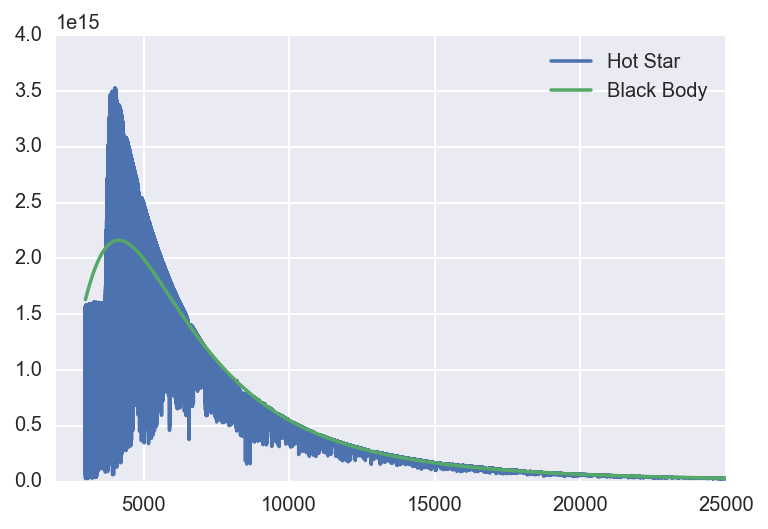

In [13]:
plt.plot(mygrid.wl, flux_A, label='Hot Star')
plt.plot(wavelengths.value, bb_A_AtSurface.value, label='Black Body')

plt.legend(loc='best')
#plt.yscale('log')
plt.xlim(2000, 25000)

## Integrate the flux to see if we get the same number.

In [14]:
from scipy.integrate import trapz

In [15]:
from Starfish import constants as C

In [16]:
#convert from erg/cm^2/s/cm to erg/cm^2/s/A
F_bol_A = trapz(flux_A*1e-8, mygrid.wl)
L_bol_A = F_bol_A / C.F_sun

In [17]:
#convert from erg/cm^2/s/cm to erg/cm^2/s/A
F_bol_BB = trapz(bb_A_AtSurface.value*1e-8, mygrid.wl)
L_bol_BB = F_bol_BB / C.F_sun

In [18]:
L_bol_A, L_bol_BB

(1.9864319078110602, 1.9713930549526408)

Voila!